In [5]:
# Fetch stored dataset from google drive or manually upload zip files and then unzip
# upload '.pth' models and set the model_path accordingly.

from google.colab import drive
drive.mount('/content/drive')

!unzip drive/My\ Drive/ASL/asl_alphabet_test.zip -d /content/

model_path = "resnet18.pth"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  drive/My Drive/ASL/asl_alphabet_test.zip
replace /content/asl_alphabet_test/space_test.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


<ipython-input-6-5fba2c7bbce4>:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=device)



Test Accuracy: 64.29%


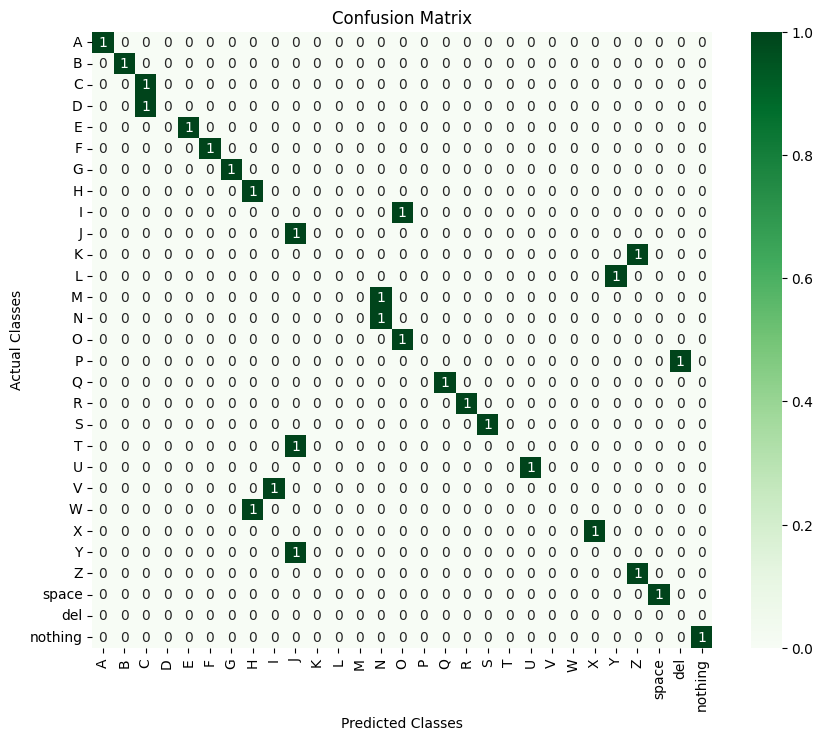

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       0.50      1.00      0.67         1
           3       0.00      0.00      0.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       0.50      1.00      0.67         1
           8       0.00      0.00      0.00         1
           9       0.33      1.00      0.50         1
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          13       0.50      1.00      0.67         1
          14       0.50      1.00      0.67         1
          15       0.00      0.00      0.00         1
          16       1.00      1.00      1.00         1
          17       1.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

In [6]:
import os
from PIL import Image
import torch
import time
import tqdm
import numpy as np
import pandas as pd
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import Dataset, DataLoader

LABEL_MAPPING = {
    'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7,
    'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15,
    'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23,
    'Y': 24, 'Z': 25, 'space': 26, 'del': 27, 'nothing': 28
}

# Testing Dataset
class ASLTestDataset(Dataset):
    def __init__(self, root='./asl_alphabet_test', transform=None, label_mapping=None):
        if not os.path.exists(root):
            raise FileNotFoundError(f"Dataset root path '{root}' does not exist!")
        self.folder_path = root
        self.image_files = [f for f in os.listdir(self.folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
        if not self.image_files:
            raise ValueError(f"No valid image files found in '{root}'!")
        self.transform = transform
        self.label_mapping = label_mapping or LABEL_MAPPING
        self.label_mapping_inv = {v: k for k, v in self.label_mapping.items()}  # Reverse mapping

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.folder_path, img_name)

        # Load image
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        # Extract label from filename and map it to an integer
        label_char = img_name.split('_')[0]
        if label_char not in self.label_mapping:
            raise ValueError(f"Unknown label '{label_char}' in filename '{img_name}'. Ensure all labels are mapped.")

        label = self.label_mapping[label_char]
        return image, label

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize RGB channels
])

# Initialize datasets
test_dataset = ASLTestDataset(transform=test_transform)

# Create DataLoaders
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.load(model_path, map_location=device)

# Transfer the model to the desired device
model = model.to(device)

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1)
        all_preds.append(pred)
        all_targets.append(target)

all_preds = torch.cat(all_preds)
all_targets = torch.cat(all_targets)

# Calculate accuracy
correct = all_preds.eq(all_targets).sum().item()
total = all_targets.size(0)
accuracy = 100 * correct / total
print(f"\nTest Accuracy: {accuracy:.2f}%")

# Compute and plot the confusion matrix
conf_matrix = confusion_matrix(all_targets.cpu(), all_preds.cpu())
class_labels = list(LABEL_MAPPING.keys())
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('Actual Classes')
plt.title('Confusion Matrix')
plt.show()

report = classification_report(all_targets.cpu(), all_preds.cpu())
print(report)
